In [1]:
from datetime import datetime
from decimal import Decimal
from typing import Optional

import typer

import matplotlib.pyplot as plt
from matplotlib import dates as mdates
from matplotlib.patches import Rectangle
plt.rcParams['font.family'] = ['Maple Mono NF CN']
plt.rcParams['figure.dpi'] = 200

from binance_api import (
    BinanceAPIError,
    BinanceDeliveryTrading,
    BinanceMarketData,
    OrderRequest,
    build_client_from_env,
)

已获取 96 条K线，示例: [[1762394400000, '103328.2', '103355.1', '102914.9', '102921.0', '12042.748', 1762395299999, '1242070741.3103', 2081, '2878.655', '297300181.4936', '0']]


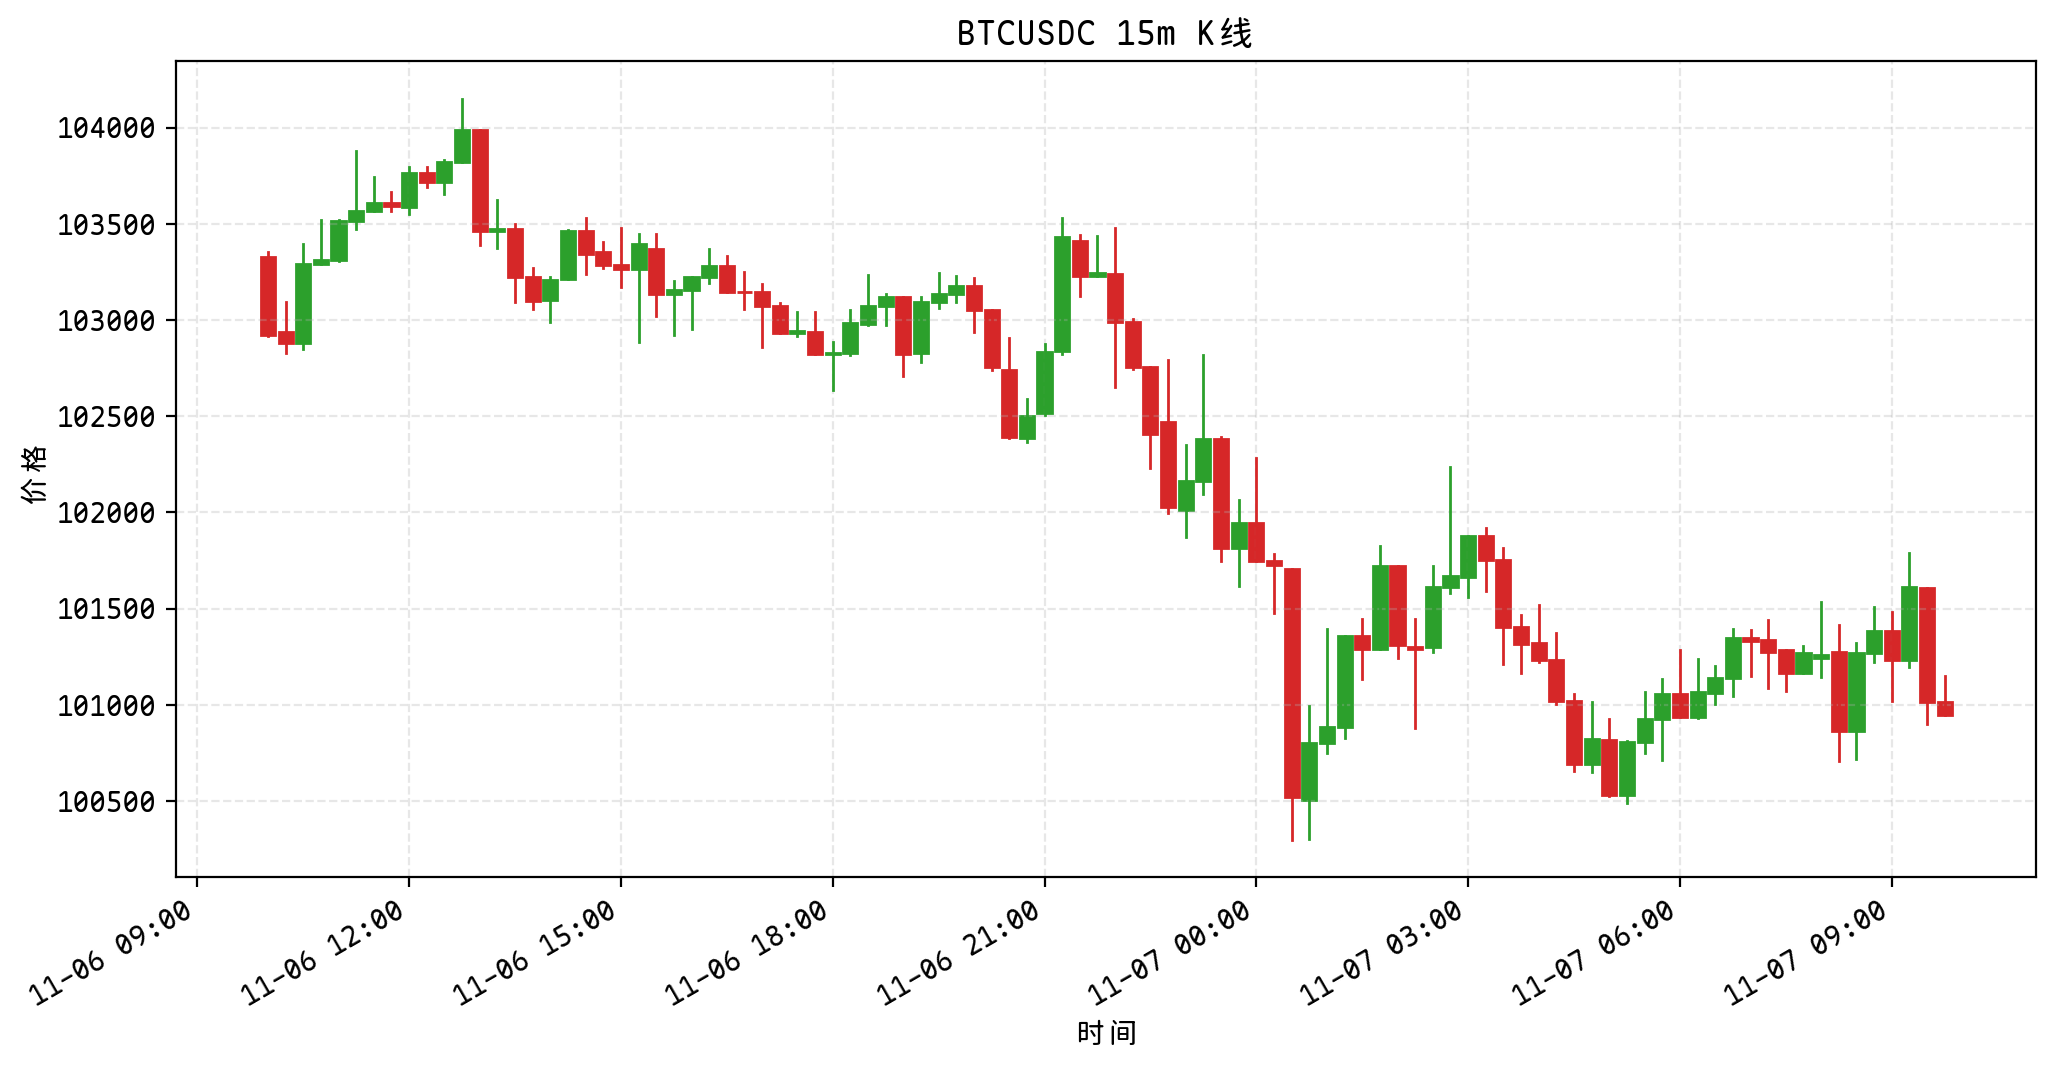

In [2]:
def _plot_klines_15m(klines: list[list], symbol: str, save_path: Optional[str]) -> None:
    if not klines:
        typer.echo("没有获取到任何K线数据。")
        return

    times = [datetime.fromtimestamp(item[0] / 1000) for item in klines]
    opens = [float(item[1]) for item in klines]
    highs = [float(item[2]) for item in klines]
    lows = [float(item[3]) for item in klines]
    closes = [float(item[4]) for item in klines]

    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_title(f"{symbol} 15m K线")
    ax.set_xlabel("时间")
    ax.set_ylabel("价格")

    ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d %H:%M"))
    fig.autofmt_xdate()

    candle_width = (15 / (24 * 60)) * 0.8

    for idx, time_point in enumerate(times):
        open_price = opens[idx]
        close_price = closes[idx]
        high_price = highs[idx]
        low_price = lows[idx]
        color = "tab:red" if close_price <= open_price else "tab:green"

        ax.plot([time_point, time_point], [low_price, high_price], color=color, linewidth=1)

        height = abs(close_price - open_price)
        if height == 0:
            height = max(open_price, close_price) * 0.0001
        rect = Rectangle(
            (mdates.date2num(time_point) - candle_width / 2, min(open_price, close_price)),
            candle_width,
            height,
            facecolor=color,
            edgecolor=color,
            linewidth=1,
        )
        ax.add_patch(rect)

    ax.grid(True, linestyle="--", alpha=0.3)

    if save_path:
        plt.savefig(save_path, bbox_inches="tight")
        typer.echo(f"K线图已保存至 {save_path}")
    else:
        plt.show()


def show_klines(
    symbol: str = typer.Option("BTCUSD_PERP", help="交易对"),
    limit: int = typer.Option(96, min=1, max=1500, help="返回的K线数量"),
    save_path: Optional[str] = typer.Option(None, help="保存图片的路径，默认直接展示"),
) -> None:
    """获取并绘制 15 分钟 K 线示例。"""
    client = build_client_from_env()
    market_data = BinanceMarketData(client)

    try:
        klines = market_data.get_klines(symbol=symbol, interval="15m", limit=limit)
        typer.echo(f"已获取 {len(klines)} 条K线，示例: {klines[:1]}")
        _plot_klines_15m(klines, symbol, save_path)
    except (ValueError, RuntimeError) as exc:
        typer.echo(f"获取或绘制K线失败: {exc}")


show_klines(symbol="BTCUSDC", limit=96, save_path=None)